# Extract and compare DEM elevation with ICESat-2 Points
1. Merge DEMs strips is more than 1
2. Extract Elevation for DEM
3. Note Time and Time difference between acquisition of ICESat-2, DEM imagery, and if DEM composed of cross-track imageries

May 07, 2020  

In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 7), 'font.size': 10})

import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gpd
import xarray as xr
# import rasterio as rio

import hvplot
import geoviews as gv
import hvplot.pandas
import hvplot.xarray

In [3]:
# Choose Icesat-2 Product
short_name = 'ATL06'

# Setup data paths
region = 'arcticdem_02_greenland_southeast'#'old prefix region replaced by arcticdem'
dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:' '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
dem_type = ['REMA', 'EarthDEM', 'ArcticDEM']
dem_type = dem_type[2] # MUST CHOOSE
# Here we will start to ICESat-2 because all of these have corresponding DEM folder
base_icesat2_path = f'/fs/project/howat.4/icesat2/{dem_type}_new/{region}_{short_name}' # Set the icesat2_path : where ICESat-2 files are staged
strips = os.listdir(base_icesat2_path)
# Select a particular satellite, WV03 for example
# strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

1271

In [4]:
# NB: Strips for merging vertically
# strip = strips[-2], ie: 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101' for region_02_greenland_southeast

In [5]:
# fig_folder = '/home/yadav.111/figs_icesat/ATL06'
analysis_folder = f'/fs/project/howat.4/icesat2/prototyping/analysis/{dem_type}/{region}'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

# strip = 'W1W1_20190416_1020010084CEDB00_1020010085562400_2m_lsf_v030403'
strip = strips[200]
print(strip)
icesat2_path = f'{base_icesat2_path}/{strip}'
files = os.listdir(f'{icesat2_path}')

outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')


hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
csv_files = [f for f in files if f.endswith('.csv') and 'ATL06' in f]

WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_v040002


In [6]:
icesat2_path

'/fs/project/howat.4/icesat2/ArcticDEM_new/arcticdem_02_greenland_southeast_ATL06/WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_v040002'

In [7]:
shp_files

['processed_ATL06_20190420075634_03370303_003_01.shp',
 'processed_ATL06_20190424203307_04060305_003_01.shp',
 'processed_ATL06_20190519063231_07790303_003_01.shp',
 'processed_ATL06_20190523062411_08400303_003_01.shp',
 'processed_ATL06_20190523190904_08480305_003_01.shp']

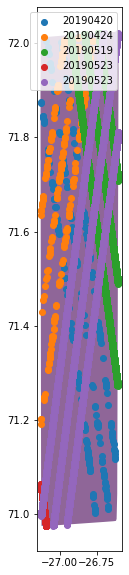

In [8]:
# Quick Check for Data
ax = outline.plot(column='seg_id', alpha=.6, lw=1, figsize=(10,10))
for shp in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{shp}', parse_dates=True)
    lbl = shp.split('_')[2][:8] #pd.to_datetime(shp.split('_')[2][:8])
    gdf.plot(ax=ax, label=lbl)
plt.legend(loc=1);

In [9]:
# Pick the largest granule for quick visualization only
sz_list = [os.path.getsize(f'{icesat2_path}/{hdf}') for hdf in hdf_files]
idx = sz_list.index(max(sz_list)) #largest index
print('No of shp files',len(shp_files), len(hdf_files))
# print(outline.area)

fname = shp_files[idx].split('.shp')[0]

No of shp files 5 5


In [10]:
shp_files

['processed_ATL06_20190420075634_03370303_003_01.shp',
 'processed_ATL06_20190424203307_04060305_003_01.shp',
 'processed_ATL06_20190519063231_07790303_003_01.shp',
 'processed_ATL06_20190523062411_08400303_003_01.shp',
 'processed_ATL06_20190523190904_08480305_003_01.shp']

## Choose a corresponding DEM Strip for Analysis

Some metadata info about DEMs and Orthos
https://www.pgc.umn.edu/guides/arcticdem/data-description/#section-3  
_matchtag.tif – Bitmask raster indicating DEM pixels derived from a stereo match (1) or those that have been interpolated (0)
0 edge 1 1
1 water 1 0
2 cloud 1 0


In [11]:
## Now get the DEM (Rema for example)

# strip_version = ['v4', 'unf']
# strip_version = strip_version[0] #choose based on how folder names look

# strips_folder = f'{dir_prefix}/{dem_type}/{region}/strips_v4/2m' #f'{dir_prefix}/EarthDEM/{region}/strips_unf/2m' #for Alaska but not tried yet as ATL06 does not exist for this region
# strips = os.listdir(f'{strips_folder}') Done use this, use the ones got from icesat-2 listing

# strips_folder = f'' #f'{dir_prefix}/EarthDEM/{region}/strips_unf/2m' #for Alaska but not tried yet as ATL06 does not exist for this region
# dem_folder =    f'{strips_folder}/{strip}'
# dem_folder = f'{dir_prefix}/{REMA}/{region}/strips_unf/2m/{strip}'
dem_folder =    f'{dir_prefix}/{dem_type}/{region}/strips_v4/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_seg1_dem.tif',
 'WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_seg1_ortho.tif',
 'WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_seg1_dem_10m.tif',
 'WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_seg1_matchtag.tif',
 'WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_seg1_bitmask.tif']

In [12]:
outline#.name.values[0]#==outline.name.values[1]

strip  version  seg_id  \
0  WV02_20190503_1030010092174B00_103001008F53170...  v040002       1   

                 time1                time2      rmse  \
0  2019/05/03 14:17:14  2019/05/03 14:18:47  0.327972   

                                            geometry  
0  POLYGON ((-27.12728 71.89125, -27.12526 72.005...

In [13]:
# Load ATL parsed data
# fname = 'processed_ATL06_20190319214810_12440205_003_01'#'processed_ATL06_20190303015545_09870205_002_01' # choose file overwriting previous choice
df = pd.read_csv(f'{icesat2_path}/{fname}.csv', parse_dates=True)
gdf = gpd.read_file(f'{icesat2_path}/{fname}.shp', parse_dates=True)
# Pick only the good quality data [verify if zero or one means good]
df = df[df.q_flag==0]
gdf = gdf[gdf.q_flag==0]
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
#Also reset index
gtls = list(df.strip.unique())
print(len(df), gtls)
# gv.tile_sources.ESRI * gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])

21798 ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [14]:
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, color='strip', s=10, alpha=0.7, width=500, height=600)
terrain_scatter = df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters').relabel('Elevation') # by='strip', 
dem_outline = outline.hvplot(geo=True, color='seg_id', alpha=.4)
fig1 = base * dem_outline * gtracks + terrain_scatter
# hvplot.save(fig1, f'{analysis_folder}/test.png') #not working newly due to path for firefox or chromium
fig1

/home/yadav.111/miniconda3/lib/python3.7/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


:Layout
   .Overlay.I           :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Polygons.I :Polygons   [Longitude,Latitude]   (seg_id)
      .Points.I   :Points   [Longitude,Latitude]   (strip)
   .NdOverlay.Elevation :NdOverlay   [strip]
      :Scatter   [h_li]   (lat)

In [15]:
# To Pick the DEM segment with most overlap IC02
# outline.crs, gdf.crs
# outline.hvplot(geo=True, color='seg_id', alpha=.4)

In [16]:
# outline.cx[:, :2]
# from earthpy import clip as cl : moved to geopandas and fixed here

In [17]:
# For a whole DEM outline, what is the intersection with specific icesat gt 
for fname in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{fname}')
    print(f'{fname}: {len(gdf)}')
    for row in outline.iterrows():
        try:
            clip = gpd.clip(gdf, gpd.GeoSeries(row[1]['geometry'], crs = outline.crs)) #crs required for both inputs
            print(f'\t{row[0]}: {len(clip)}')
        except:
            print(f'No Overlap {row[0]}')
            

processed_ATL06_20190420075634_03370303_003_01.shp: 297
	0: 297
processed_ATL06_20190424203307_04060305_003_01.shp: 228
	0: 228
processed_ATL06_20190519063231_07790303_003_01.shp: 16410
	0: 16410
processed_ATL06_20190523062411_08400303_003_01.shp: 782
	0: 782
processed_ATL06_20190523190904_08480305_003_01.shp: 28687
	0: 28687


<AxesSubplot:>

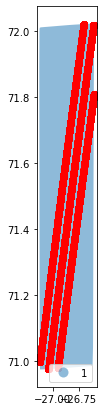

In [22]:
# gpd.GeoSeries(row[1]['geometry'])
ax = outline.plot(column='seg_id', categorical=True, alpha=.5, legend=True)
gdf.plot(ax=ax, c='r')

In [23]:
# Some dems has gaps in between segments, eg: /fs/byo/howat-data5/ArcticDEM/region_02_greenland_southeast/strips_v4/2m/W1W2_20190428_102001008466F300_1030010090702200_2m_lsf_v040002
# so icesat-2 will has gaps as well; to make it contineous 

In [24]:
# df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters', subplots=True)

In [25]:
# What is the time difference between Icesat and DEM
time_diff = pd.to_datetime(fname.split('_')[2]) - pd.to_datetime(strip.split('_')[1])
print(time_diff)

20 days 19:09:04


In [26]:
dem_folder

'/fs/byo/howat-data5/ArcticDEM/arcticdem_02_greenland_southeast/strips_v4/2m/WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_v040002'

In [27]:
# If there is more than one DEM, find a way to merge them into one seamless DEM
segments = [tif.split('_')[-2] for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
segments.sort() #This is inplace sorting
print(len(segments))
segments

1


['seg1']

In [28]:
# dem_tif = [tif.split('_seg')[0] for tif in os.listdir(dem_folder)] # if tif.endswith('_dem.tif')

In [29]:
# Get full base path for all DEMs and Orthos and Matchtags
# Pick a segment : one or more
seg = segments[-1]
dem_prefix = '_'.join(strip.split('_')[:-1])
dem_prefix = f'{dem_folder}/{dem_prefix}_{seg}'

dem = f'{dem_prefix}_dem.tif'
print(dem)
matchtag = f'{dem_prefix}_matchtag.tif'
bitmask = f'{dem_prefix}_bitmask.tif'
ortho = f'{dem_prefix}_ortho.tif'
os.path.exists(dem), os.path.exists(matchtag), os.path.exists(bitmask), os.path.exists(ortho)

/fs/byo/howat-data5/ArcticDEM/arcticdem_02_greenland_southeast/strips_v4/2m/WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_v040002/WV02_20190503_1030010092174B00_103001008F531700_2m_lsf_seg1_dem.tif


(True, True, True, True)

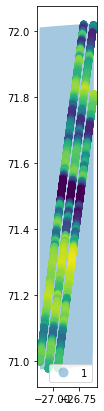

In [31]:
# Overview of how ground-tracks intersect with DEM outline
ax = outline.plot(column='seg_id', alpha=.4, categorical=True, legend=True)
# outline[outline.seg_id==int(seg.strip('seg'))].plot(ax=ax, color='r')

gdf.plot(ax=ax, column='h_li');

## Use Xarray load and analyze DEM

In [32]:
dem = xr.open_rasterio(dem) #, chunks={'x':2**11, 'y':2**11}
dem = dem.load()
# da = xr.open_rasterio(f'{dem_folder}/{ortho_tif}')

In [33]:
nodata_value = dem.attrs['nodatavals'][0]
dem.data[dem.data==nodata_value] = np.nan # dem.datareplace no-data with NANs
print(nodata_value)

-9999.0


In [34]:
# dem.sel(band=1).plot.imshow(cmap='viridis', robust=True);

In [35]:
# matchtag = xr.open_rasterio(matchtag)
bitmask = xr.open_rasterio(bitmask)

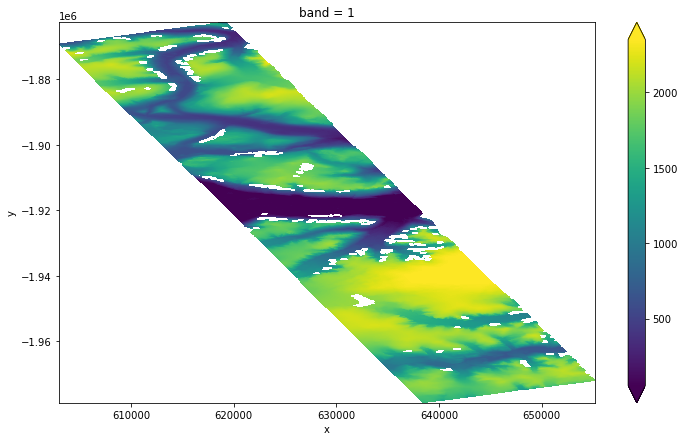

In [36]:
# Mask out problematic DEM values based matchtag mask [remove value = 0 or keep value == 1]; ie, put NANs whereever matchtag NOT == 1
# dem = dem.where(matchtag.data==1)
dem = dem.where(bitmask.data==0)
# matchtag.sel(band=1).plot.imshow();
dem.sel(band=1).plot.imshow(cmap='viridis', robust=True);

In [37]:
# bitmask.sel(band=1).plot.imshow(robust=True);

In [38]:
# gv.from_xarray(dem) #crashed jupyter; try on smaller data

In [39]:
dem.crs

'+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True'

In [40]:
# Change Icesat shapefile projection to match DEM's projection
# Else can't extract elevation from DEM
# Required to overlay plots as well
proj4 = dem.crs #dem.projection.ExportToProj4() # but there is extra space at the end
gdf1 = gdf.to_crs(proj4).copy()
# gdf1.iloc[1].geometry.x, gdf1.iloc[1].geometry.y

In [41]:
len(gdf1)

28687

In [42]:
gdf1

t_dt         h_li  q_flag strip  \
0      2019-05-23 19:11:51.527000  2106.603271       0  gt1l   
1      2019-05-23 19:11:51.530000  2105.787354       0  gt1l   
2      2019-05-23 19:11:51.533000  2104.964111       0  gt1l   
3      2019-05-23 19:11:51.536000  2104.104980       0  gt1l   
4      2019-05-23 19:11:51.538000  2103.216797       0  gt1l   
...                           ...          ...     ...   ...   
28682  2019-05-23 19:12:04.647000  1808.182861       0  gt3r   
28683  2019-05-23 19:12:04.650000  1806.612915       0  gt3r   
28684  2019-05-23 19:12:04.653000  1805.161499       0  gt3r   
28685  2019-05-23 19:12:04.656000  1803.733032       0  gt3r   
28686  2019-05-23 19:12:04.658000  1802.340454       0  gt3r   

                              geometry  
0      POINT (626994.037 -1885564.751)  
1      POINT (626997.670 -1885584.318)  
2      POINT (627001.327 -1885603.892)  
3      POINT (627005.008 -1885623.451)  
4      POINT (627008.718 -1885643.015)  
...                                ...  
28682  POINT (637353.722 -1975783.944)  
28683  POINT (637357.394 -1975803.555)  
28684  POINT (637361.064 -1975823.165)  
28685  POINT (637364.729 -1975842.776)  
28686  POINT (637368.392 -1975862.389)  

[28687 rows x 5 columns]

## Extraction pixel value from raster for each point

In [43]:
def getPixVal(pt):
    """ Given a Geopandas/Shapely Point geometry, extract the pixel value from the Xarray raster """
    #x, y = pt.coords[:][0]
    out = dem.sel(x = pt.x, y=pt.y, method='nearest')
    return out.values[0]

In [44]:
gdf1['dem'] = gdf1.geometry.apply(getPixVal)

In [45]:
nan_count = len(gdf1[np.isnan(gdf1.dem)])
print(nan_count)
print('Nans Fraction: ', nan_count/len(gdf1))

1111
Nans Fraction:  0.03872834384913027


In [46]:
gdf1 = gdf1.dropna() #Drop the Nans from the edges of DEM
gdf1['dif'] = gdf1.h_li - gdf1.dem
gdf1 = gdf1.drop(['t_dt', 'q_flag'], axis=1)

/home/yadav.111/miniconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [47]:
len(gdf1), len(gdf)

(27576, 28687)

In [48]:
gdf1.strip.value_counts()

gt2l    5195
gt2r    5045
gt3l    4862
gt3r    4573
gt1l    3991
gt1r    3910
Name: strip, dtype: int64

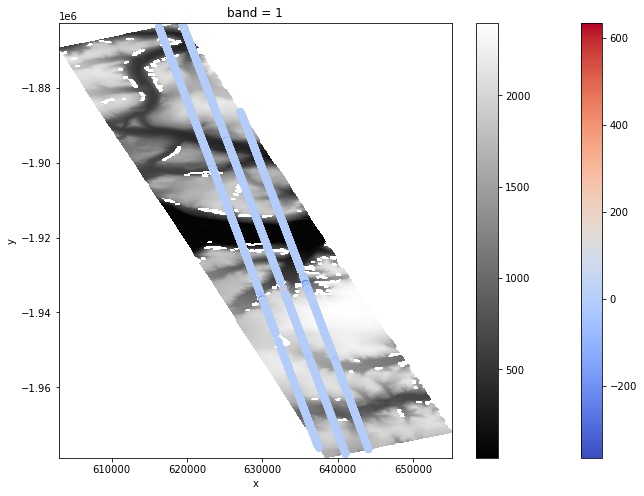

In [49]:
# da.plot.imshow(cmap='gist_earth')
ax = gdf1.plot(column='dif', cmap='coolwarm', legend=True, figsize=(11, 8))
# ax = gdf1.plot(column='dif', legend=True, figsize=(11, 8))
dem.sel(band=1).plot.imshow(ax=ax, cmap='gray');

In [50]:
gdf1.tail(2)

h_li strip                         geometry          dem  \
28661  1840.659302  gt3r  POINT (637276.752 -1975372.109)  1844.207764   
28662  1838.988159  gt3r  POINT (637280.470 -1975391.709)  1842.694702   

            dif  
28661 -3.548462  
28662 -3.706543

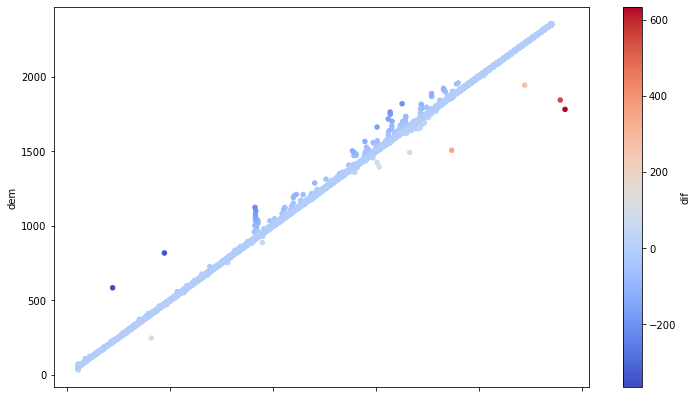

In [51]:
gdf1[['h_li','dem', 'dif']].plot(kind='scatter', x=0, y=1, c='dif', cmap='coolwarm');

<AxesSubplot:>

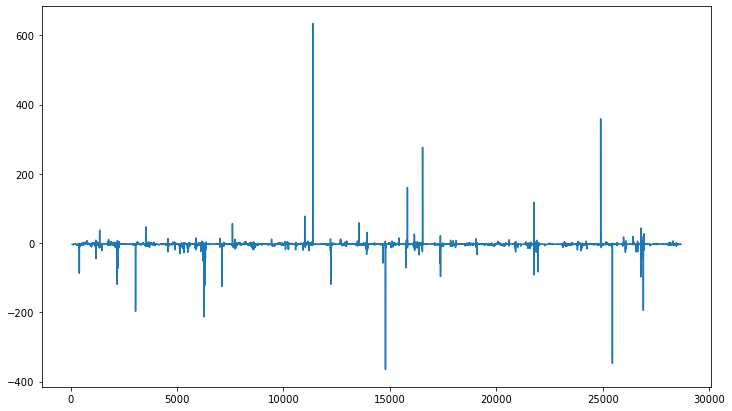

In [52]:
gdf1.dif.plot()

In [53]:
# df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters', subplots=True)

In [54]:
# gdf1[['h_li','dem']].hvplot(kind='scatter', x=0, y=1);
gdf1[['h_li','dem', 'strip']].hvplot(y='dem', x='h_li', kind='scatter', by='strip', subplots=False)

:NdOverlay   [strip]
   :Scatter   [h_li]   (dem)

In [55]:
gdf1[gdf1.strip=='gt3r'][['h_li','dem']].hvplot(kind='scatter', alpha=.5)

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

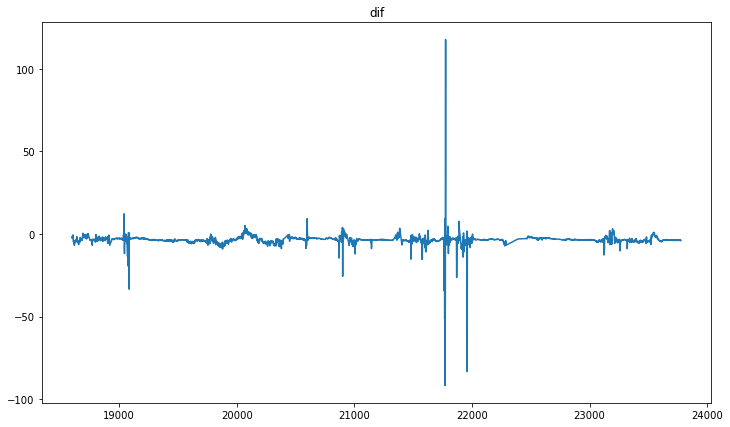

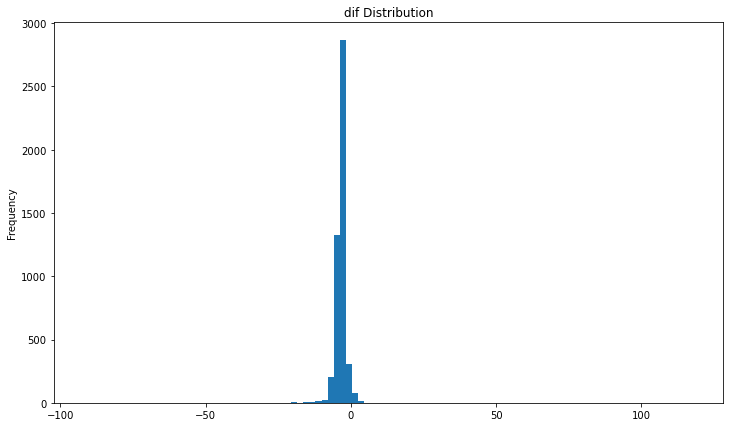

In [56]:
gdf1[gdf1.strip=='gt3l'].dif.plot(title='dif')
plt.figure()
gdf1[gdf1.strip=='gt3l'].dif.plot(kind='hist', bins=100, title='dif Distribution');

In [57]:
# ortho_tif
ortho = xr.open_rasterio(ortho)#.load()
# nodata_value = ortho.attrs['nodatavals'][0]
# # First conver to fload, so it can be converted to nan
# ortho.data = ortho.data.astype(float)

# ortho.data[ortho.data==nodata_value] = np.nan
# print(nodata_value)

In [58]:
np.nanmax(ortho.data)

2089

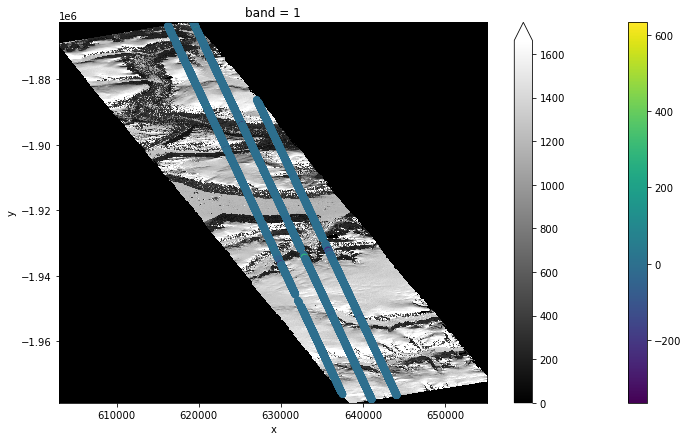

In [59]:
ax = gdf1.plot(column='dif', legend=True)
ortho.sel(band=1).plot.imshow(ax=ax, robust=True, cmap='gray'); #, cmap='gist_earth'

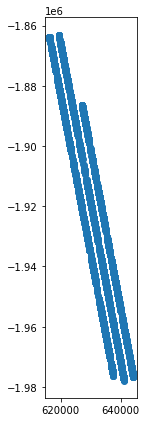

In [60]:
gdf1[np.abs(gdf1.dif)>3].plot();

In [61]:
# gdf2 = gdf1.reset_index(drop = True)

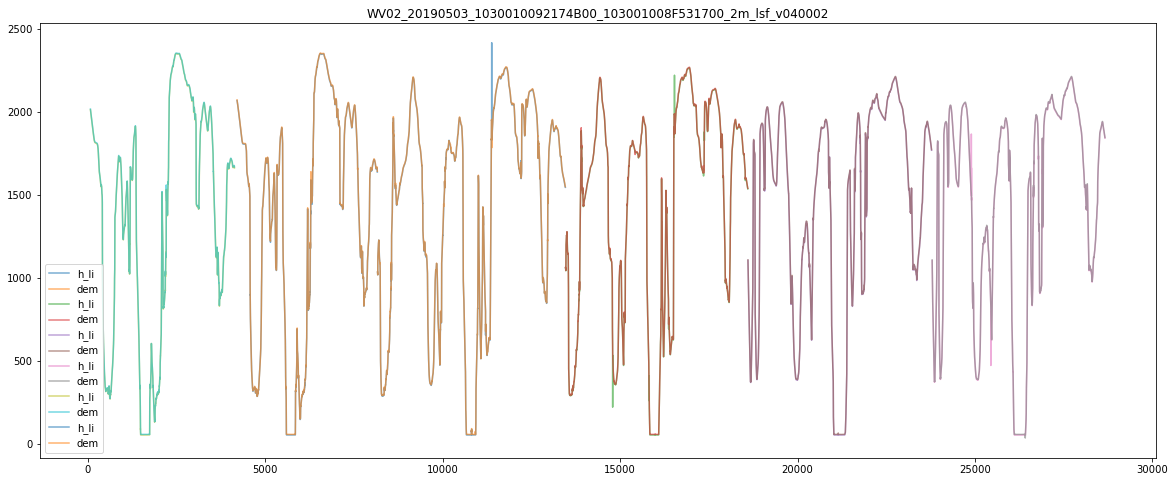

In [62]:
gtls = list(gdf1.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# gtl = gtls[2]
fig, ax = plt.subplots(figsize=(20, 8))
for gtl in gtls:
    gdf1[gdf1.strip==gtl][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax);

In [63]:
gtls

['gt2l', 'gt2r', 'gt3l', 'gt3r', 'gt1l', 'gt1r']

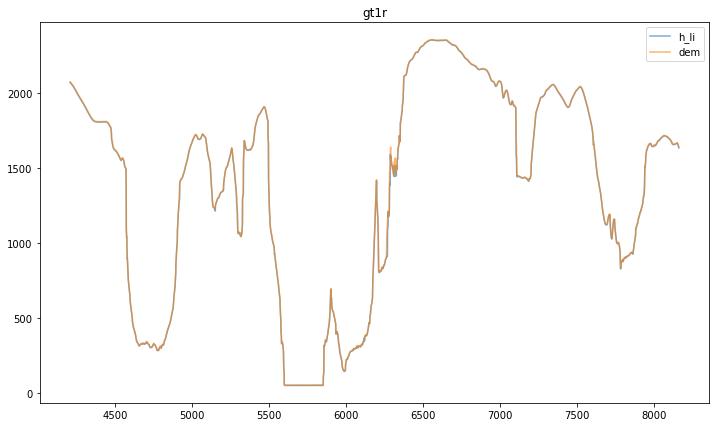

In [64]:
gdf1[gdf1.strip==gtl][['h_li', 'dem']].plot(style='-', alpha=.6, title=gtl);

In [65]:
# gdf1[gdf1.strip==gtl].reset_index()[['h_li', 'dem']].plot(style='-', alpha=.6, title=gtl);

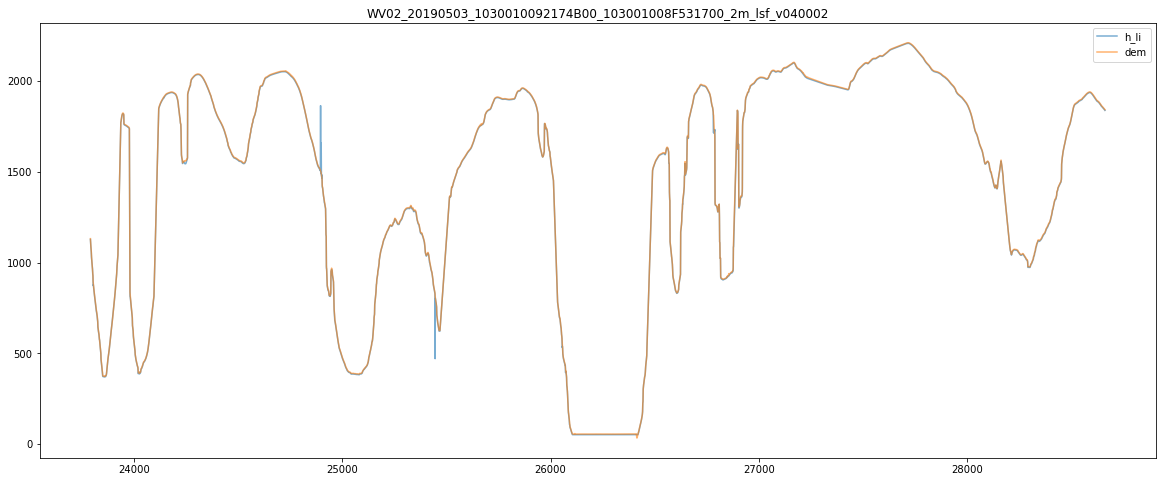

In [66]:
# gdf[['h_li', 'dem']].plot()
fig, ax = plt.subplots(figsize=(20, 8))
# gdf2[gdf2.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf1[gdf1.strip==gtls[3]][['h_li', 'dem']].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

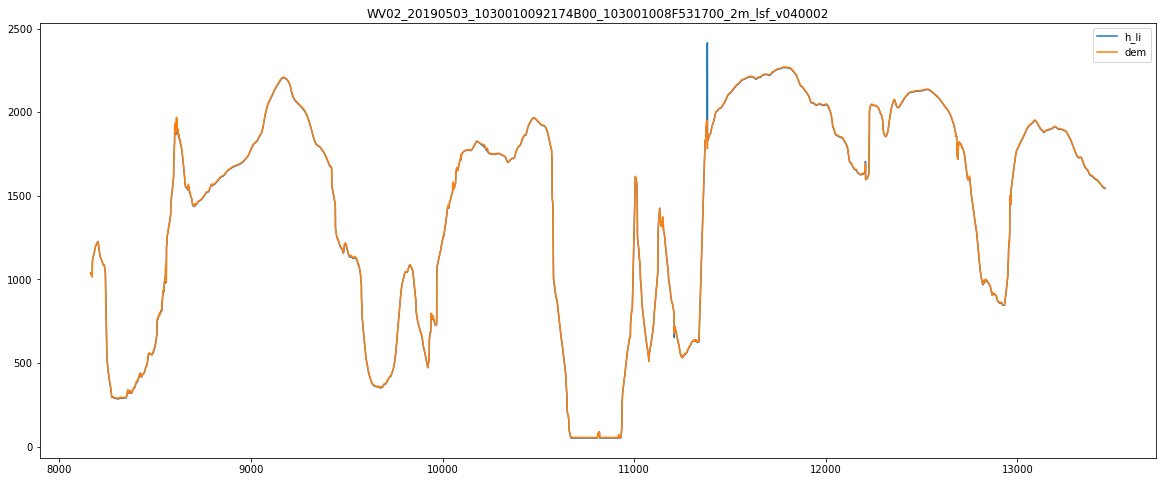

In [67]:
fig, ax = plt.subplots(figsize=(20, 8))
# gdf1[gdf1.strip==gtls[0]][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', title=strip, ax=ax); #, ax=ax
gdf1[gdf1.strip==gtls[0]][['h_li', 'dem']].plot(style='-', title=strip, ax=ax); #, ax=ax

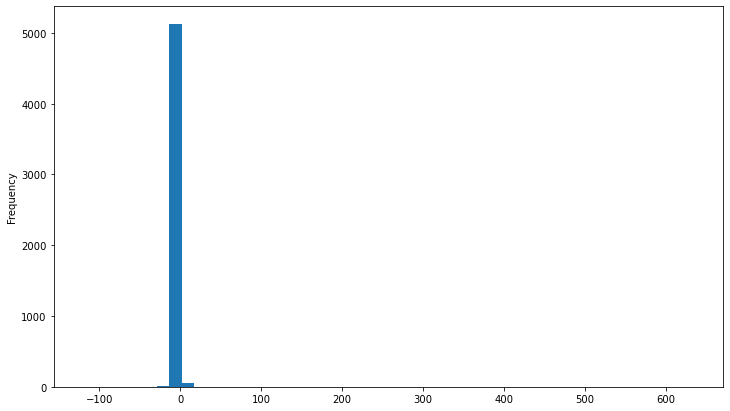

In [68]:
gdf1[gdf1.strip==gtls[0]].dif.plot(kind='hist', bins=50);

In [69]:
time_diff

Timedelta('20 days 19:09:04')

In [70]:
fname

'processed_ATL06_20190523190904_08480305_003_01.shp'

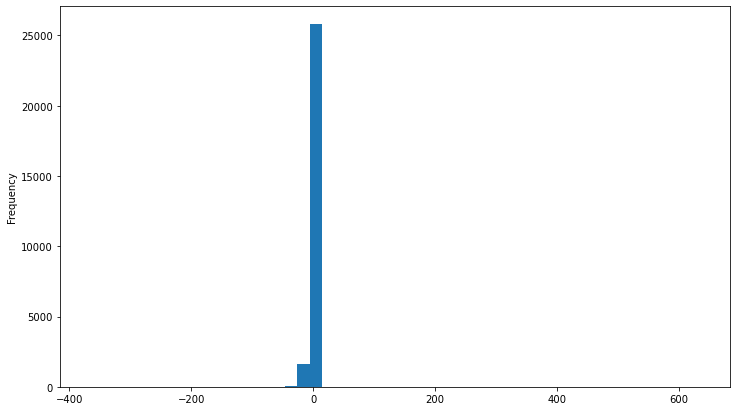

In [71]:
gdf1.dif.plot(kind='hist', bins=50);

In [72]:
gdf1.dif.mean()

-3.527537402326486

In [74]:
dfg = gdf1.groupby('strip')

In [77]:
type(dfg)

pandas.core.groupby.generic.DataFrameGroupBy

/home/yadav.111/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


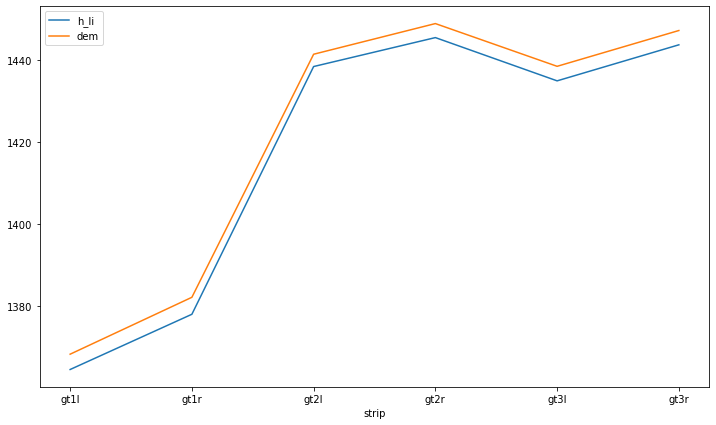

In [81]:
# dfg.dif.mean().plot(kind='bar');
pd.DataFrame(dfg[['h_li', 'dem']].mean()).plot();

In [84]:
# gtl = 'gt2'
# ax = gdf1[gdf1.strip==f'{gtl}l'][['dem','h_li']].plot(lw=4, alpha=.5)
# gdf2[gdf2.strip==f'{gtl}r'][['h_li', 'dem']].plot(ax = ax)